# MMDetection 
## Documentation: https://mmdetection.readthedocs.io/en/latest/get_started.html

# Check lib versions

In [1]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


In [2]:
# Deleting SCRATCH storage
!rm -rf $SCRATCHDIR/*

# Setup Weights & Biases

In [3]:
!pip install -q --upgrade wandb


import os
os.environ["WANDB_NOTEBOOK_NAME"] = "cell-nuclei"
import wandb
wandb.login()

wandb.__version__

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find cell-nuclei.
wandb: Currently logged in as: janburian. Use `wandb login --relogin` to force relogin


'0.16.2'

In [4]:
wandb.init(project="cell-nuclei", entity="janburian")

In [5]:
# Some basic setup
import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").absolute().parent.absolute()))

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import requests
import json

def unzip(input_file:Path, output_dir=None):
    from zipfile import ZipFile
    with ZipFile(input_file,"r") as zip_ref:
         for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
              zip_ref.extract(member=file, path=output_dir)
            
def classes_from_coco(annotation_file:Path):
    with open(annotation_file) as f:
        ann = json.load(f)
    _, cfg_classes = zip(*sorted([(cat["id"], cat["name"]) for cat in ann["categories"]]))
    return cfg_classes

def mywget(url, fname, force=False):
    fname = Path(fname)
    if fname.exists() and ~force:
        print(f"File already exists. Use force=True to owerwrite.")
        return
    fname.parent.mkdir(parents=True, exist_ok=True)
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")
    

2024-02-06 15:09:49,443 - general_logger - DEBUG - mmdet.version=2.25.0


1.12.0a0+8a1a93a True


2024-02-06 15:09:49,660 - general_logger - DEBUG - 11.7
2024-02-06 15:09:49,662 - general_logger - DEBUG - GCC 9.4


NOTE! Installing ujson may make loading annotations faster.


In [6]:
mmdet.__version__
mmdet.__file__ # path where mmdetection is saved - use it in Jupyter notebook terminal 

'/workspace/mmdetection/mmdet/__init__.py'

# Prepare data

Download and copy dataset to scratch dir.

In [7]:
scratchdir = Path(os.getenv("SCRATCHDIR", "."))
logname = Path(os.getenv("LOGNAME", "."))
# from loguru import logger

local_input_data_dir = Path(scratchdir) / "data/orig/" # original data directory
local_output_data_dir = Path(scratchdir) / "data/processed/" # processed data directory

LOCAL_INPUT_DATA_DIR = str(local_input_data_dir)
LOCAL_OUTPUT_DATA_DIR = str(local_output_data_dir)

!echo "$LOCAL_INPUT_DATA_DIR"
!echo "$LOCAL_OUTPUT_DATA_DIR"

print(local_input_data_dir)
print(local_output_data_dir)

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig
/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/processed
/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig
/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/processed


In [8]:
!pwd # print working directory

/auto/plzen1/home/jburian/projects/MMDetection_cell_nuclei


In [9]:
!mkdir -p "$LOCAL_INPUT_DATA_DIR"

# 1) copy data from your location or ...
# !cp -r ~/data/biomedical/orig/cell_nuclei_COCO.zip "$SCRATCHDIR"/data.zip
# to see progressbar we use 'rsync -ah  instead of cp
# !rsync --progress -ah -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigleg_holder.zip "$SCRATCHDIR"/data.zip

# ... or download from internet
mywget("https://github.com/janburian/Masters_thesis/raw/d5ee58b87b7c54a9f19afe2a20dff5a797ab1486/datasets/COCO_cell_nuclei.zip", scratchdir/"data.zip")
# !wget https://github.com/janburian/Masters_thesis/raw/d5ee58b87b7c54a9f19afe2a20dff5a797ab1486/datasets/COCO_cell_nuclei.zip -O "$SCRATCHDIR"/data.zip

!ls "$SCRATCHDIR"

# 2) unzip
# !unzip -o "$SCRATCHDIR"/data.zip -d "$LOCAL_INPUT_DATA_DIR" > /dev/null
unzip(scratchdir/"data.zip", local_input_data_dir)

!ls "$LOCAL_INPUT_DATA_DIR"

100%|██████████| 2.34M/2.34M [00:00<00:00, 39.6MiB/s]

data  data.zip



100%|██████████| 101/101 [00:00<00:00, 1623.50it/s]

images	trainval.json


In [10]:
# Checking directories 
!echo "$SCRATCHDIR"
# !ls "$SCRATCHDIR"
# !ls "$SCRATCHDIR"/data/orig
!ls "$LOCAL_INPUT_DATA_DIR"

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz
images	trainval.json


## Dataset paths

In [11]:
data_root = local_input_data_dir

# data_root = local_input_data_dir
img_prefix = './images'
train_ann_file = 'trainval.json'
val_ann_file  = 'trainval.json'
test_ann_file = 'trainval.json'

data_root

PosixPath('/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig')

### Train test val split

Run the following lines if you want split dataset. Change the dataset configuration in the `mmdetection` config : `cfg.train...`, `cfg.test...` and `cfg.val...`

In [12]:
# import coco_dataset

# fnin = data_root / 'trainval.json'
# # fnin= data_root / 'annotations/instances_default.json'
# fn1 = data_root / 'train.json'
# fn2 = data_root / 'test.json'
# fn3 = data_root / 'val.json'
# fntmp = data_root / 'tmp.json'
# assert fnin.exists()
# ccd = coco_dataset.CocoDataset(fnin, data_root / "images")
# ccd.train_test_split(fn1, fntmp) # 1 json => 2 jsony
# ccd = coco_dataset.CocoDataset(fntmp, data_root / "images")
# ccd.train_test_split(fn2, fn3, 0.5) # + dalsi 2 z druheho 
# assert fn3.exists()

# train_ann_file = 'train.json'
# val_ann_file  = 'val.json'
# test_ann_file = 'test.json'

# import json
# with open('val.json', 'w') as f:
#     json.dump(train_ann_file, f)

import coco_dataset
from pathlib import Path
import json

fnin = data_root / 'trainval.json'

fn1 = data_root / 'train.json'
fn2 = data_root / 'test.json'
fn3 = data_root / 'val.json'
fntmp = data_root / 'tmp.json'

assert fnin.exists()

# Split the original dataset into two parts
ccd = coco_dataset.CocoDataset(fnin, data_root / "images")
ccd.train_test_split(fn1, fntmp)

# Split the second part into validation and test sets
ccd = coco_dataset.CocoDataset(fntmp, data_root / "images")
ccd.train_test_split(fn2, fn3, test_size=0.5)

# Verify that the validation set file exists
assert fn3.exists()

# Optional: Load and display the content
with open(fn1, 'r') as f:
    train_data = json.load(f)

with open(fn2, 'r') as f:
    test_data = json.load(f)

with open(fn3, 'r') as f:
    val_data = json.load(f)
    
with open(fnin, 'r') as f:
    trainval_data = json.load(f)

# print("Train data:", train_data)
# print("Test data:", test_data)
# print("Validation data:", val_data)

print(type(train_data))

with open("train_data.json", "w") as outfile: 
    json.dump(train_data, outfile)
    
with open("val_data.json", "w") as outfile: 
    json.dump(val_data, outfile)
    
with open("test_data.json", "w") as outfile: 
    json.dump(test_data, outfile)
    
with open("trainval.json", "w") as outfile: 
    json.dump(trainval_data, outfile)

!ls "$LOCAL_INPUT_DATA_DIR"


<class 'dict'>
images	test.json  tmp.json  train.json  trainval.json	val.json


# Prepare pretrained checkpoint
### Configs
- Configs (Faster R-CNN): https://github.com/open-mmlab/mmdetection/tree/master/configs/faster_rcnn
- Configs (Mask R-CNN): https://github.com/open-mmlab/mmdetection/tree/master/configs/mask_rcnn

### Useful file (metafile.yml) for getting urls to download pretrained models:
- Faster R-CNN: https://github.com/open-mmlab/mmdetection/blob/master/configs/faster_rcnn/metafile.yml 
- Mask R-CNN: https://github.com/open-mmlab/mmdetection/blob/master/configs/mask_rcnn/metafile.yml

In [13]:
main_url_to_download_model = "https://download.openmmlab.com/mmdetection/v2.0"
path_to_model = '/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth' # mutable parameter, depends on wanted model

wget_url = main_url_to_download_model + path_to_model
model_name = os.path.basename(path_to_model).split('/')[-1]
configs_dir = os.path.split(path_to_model)[0] + ".py"

# Getting relevant model 
mywget(
    wget_url,
    scratchdir
    / str("checkpoints/" + model_name)
)

print(wget_url)
print(model_name)
print(configs_dir)
# print(type(configs_dir))
# print(type(model_name))
# print(type(wget_url))

# mywget(
#     "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_2x_coco/mask_rcnn_r50_fpn_2x_coco_bbox_mAP-0.392__segm_mAP-0.354_20200505_003907-3e542a40.pth",
#     scratchdir
#     / "checkpoints/mask_rcnn_r50_fpn_2x_coco_bbox_mAP-0.392__segm_mAP-0.354_20200505_003907-3e542a40.pth"
# )

# mywget(
#     "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_caffe_fpn_1x_coco/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth",
#     scratchdir
#     / "checkpoints/mask_rcnn_r101_caffe_fpn_1x_coco_20200601_095758-805e06c1.pth"
# )

100%|██████████| 178M/178M [00:05<00:00, 35.2MiB/s] 

https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_fpn_1x_coco/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py


In [14]:
cfg_classes = classes_from_coco(data_root / train_ann_file)
print(cfg_classes)


mmdetection_path = Path(mmdet.__file__).parent.parent
print(mmdetection_path)

logger.debug(f"outputdir={local_output_data_dir}")
logger.debug(f"input_data_dir={local_input_data_dir}")
logger.debug(f"input_data_dir exists={local_input_data_dir.exists()}")
logger.debug(f'input_data_dir glob={str(list(local_input_data_dir.glob("**/*")))}')

# Choose to use a config and initialize the detector
config = (
    mmdetection_path / str("configs" + configs_dir)
)

logger.debug(f"config.exists={config.exists()}")

# Setup a checkpoint file to load
checkpoint_pth = (
    scratchdir / str("checkpoints/" + model_name) 
)
print(checkpoint_pth)
logger.debug(f"checkpoint_pth.exists={checkpoint_pth.exists()}")

# Set the device to be used for evaluation
device = "cuda:0"

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, str(checkpoint_pth), map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint["meta"]["CLASSES"]

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)

# Convert the model into evaluation mode
model.eval()

# Use the detector to do inference
img = mmdetection_path / "demo/demo.jpg"
result = inference_detector(model, img)
model.show_result(
    img, result, out_file=local_output_data_dir / "demo_output.jpg"
)  # save image with result

2024-02-06 15:10:01,199 - general_logger - DEBUG - outputdir=/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/processed
2024-02-06 15:10:01,203 - general_logger - DEBUG - input_data_dir=/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig
2024-02-06 15:10:01,206 - general_logger - DEBUG - input_data_dir exists=True
2024-02-06 15:10:01,211 - general_logger - DEBUG - input_data_dir glob=[PosixPath('/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images'), PosixPath('/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/trainval.json'), PosixPath('/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/train.json'), PosixPath('/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/tmp.json'), PosixPath('/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/test.json'), PosixPath('/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/val.json'), PosixPath('/scratch.ssd/jburia

('cell nucleus',)
/workspace/mmdetection
/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
load checkpoint from local path: /scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth


/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


## My dataset training

In [15]:
# My dataset training
cfg = Config.fromfile(
    mmdetection_path / str("configs" + configs_dir)
)

# Modify dataset type and path
cfg.dataset_type = "CocoDataset"
cfg.data_root = str(local_input_data_dir)
cfg.classes = cfg_classes


## Coco train, val and test datasets definition
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = str(data_root)
cfg.data.train.ann_file = train_ann_file
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = img_prefix
cfg.data.train.classes = cfg.classes

cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = str(data_root)
cfg.data.test.ann_file = test_ann_file
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = img_prefix
cfg.data.test.classes = cfg.classes

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = str(data_root)
cfg.data.val.ann_file = val_ann_file
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = img_prefix
cfg.data.val.classes = cfg.classes

## Coco train, val and test datasets definition
# cfg.data.test.type = 'CocoDataset'
# cfg.data.test.data_root = str(data_root)
# cfg.data.test.ann_file = test_ann_file
# cfg.data.test.img_prefix = img_prefix
# cfg.data.test.classes = cfg.classes

# cfg.data.train.type = 'CocoDataset'
# cfg.data.train.data_root = str(data_root)
# cfg.data.train.ann_file = train_ann_file  # Corrected line
# cfg.data.train.img_prefix = img_prefix
# cfg.data.train.classes = cfg.classes

# cfg.data.val.type = 'CocoDataset'
# cfg.data.val.data_root = str(data_root)
# cfg.data.val.ann_file = val_ann_file  # Corrected line
# cfg.data.val.img_prefix = img_prefix
# cfg.data.val.classes = cfg.classes

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = len(cfg.classes)
cfg.model.roi_head.mask_head.num_classes = len(cfg.classes) # for mask segmentation
print(cfg.classes)


# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = str(
    scratchdir / str("checkpoints/" + model_name)
)


# Set up working dir to save files and logs.
cfg.work_dir = str(local_output_data_dir / "tutorial_exps")

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02/8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# cfg.train_cfg = dict(
#     type='EpochBasedTrainLoop',  # The training loop type. Refer to https://github.com/open-mmlab/mmengine/blob/main/mmengine/runner/loops.py
#     max_epochs=50,  # Maximum training epochs
#     val_interval=1)  # Validation intervals. Run validation every epoch.

cfg.runner.max_epochs = 100

# cfg.val_cfg = dict(type='ValLoop')  # The validation loop type
# cfg.test_cfg = dict(type='TestLoop')  # The testing loop type

# Change the evaluation metric since we use customized dataset.
# cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 100
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

def is_mlu_available():
    """Returns a bool indicating if MLU is currently available."""
    return hasattr(torch, 'is_mlu_available') and torch.is_mlu_available()


def get_device():
    """Returns an available device, cpu, cuda or mlu."""
    is_device_available = {
        'cuda': torch.cuda.is_available(),
        'mlu': is_mlu_available()
    }
    device_list = [k for k, v in is_device_available.items() if v]
    return device_list[0] if len(device_list) == 1 else 'cpu'

cfg.device = get_device()


# We can also use Wandb to log the training process
cfg.log_config.hooks = [
    dict(type="TextLoggerHook"),
    dict(
        type="MMDetWandbHook",
        init_kwargs={"project": "cell-nuclei"},
        interval=10,
        log_checkpoint=True,
        log_checkpoint_metadata=True,
        num_eval_images=5,
        bbox_score_thr=0.3,
    ),
]

# Save models
model_output_directory
default_hooks = dict(checkpoint=dict(type='CheckpointHook', interval=5, out_dir='/auto/plzen1/home/jburian/projects/MMDetection_cell_nuclei/models/cell_nuclei_segmentation'))

# Augmentations
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Resize', img_scale=(256, 256), keep_ratio=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]

# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}') # does not work for paths beginning '/' because of bug in lib2to3

# logger.debug(f"cfg=\n{pformat(cfg)}")
print(f'Config:\n{cfg.pretty_text}')

# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

logger.debug(f"classes={datasets[0].CLASSES}")

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)
print(len(cfg_classes))

# cfg.model.roi_head.bbox_head.num_classes = len(cfg.classes)

('cell nucleus',)


2024-02-06 15:10:06,805 - general_logger - DEBUG - classes=('cell nucleus',)


Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_wei

2024-02-06 15:10:07,351 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-02-06 15:10:07,369 - mmdet - INFO - load checkpoint from local path: /scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/checkpoints/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth
2024-02-06 15:10:07,556 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpo

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2024-02-06 15:10:07,559 - mmdet - INFO - Start running, host: jburian@cha.natur.cuni.cz, work_dir: /scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/processed/tutorial_exps
2024-02-06 15:10:07,563 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) MMDetWandbHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
(VERY_LOW    ) MMDetWandbHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) It

2024-02-06 15:10:15,458 - mmdet - WARNING - No meta information found in the runner. 
wandb: Waiting for artifact val to be committed...



wandb: Committed artifact janburian/cell-nuclei/val:v16
wandb:   12 of 12 files downloaded.  
2024-02-06 15:10:31,949 - mmdet - INFO - Epoch [1][10/38]	lr: 2.500e-03, eta: 1:01:53, time: 0.980, data_time: 0.699, memory: 3085, loss_rpn_cls: 0.4472, loss_rpn_bbox: 0.1521, loss_cls: 0.4770, acc: 78.3203, loss_bbox: 0.5746, loss_mask: 0.6362, loss: 2.2872
2024-02-06 15:10:36,080 - mmdet - INFO - Epoch [1][20/38]	lr: 2.500e-03, eta: 0:43:52, time: 0.413, data_time: 0.171, memory: 3085, loss_rpn_cls: 0.1214, loss_rpn_bbox: 0.1107, loss_cls: 0.3617, acc: 84.0332, loss_bbox: 0.6303, loss_mask: 0.4361, loss: 1.6603
2024-02-06 15:10:40,062 - mmdet - INFO - Epoch [1][30/38]	lr: 2.500e-03, eta: 0:37:30, time: 0.398, data_time: 0.166, memory: 3085, loss_rpn_cls: 0.0831, loss_rpn_bbox: 0.1287, loss_cls: 0.3048, acc: 87.0801, loss_bbox: 0.6138, loss_mask: 0.3239, loss: 1.4543
2024-02-06 15:10:53,362 - mmdet - INFO - Epoch [2][10/38]	lr: 2.500e-03, eta: 0:36:06, time: 0.980, data_time: 0.701, memory:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 7.2 task/s, elapsed: 2s, ETA:     0s

2024-02-06 15:47:06,859 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2024-02-06 15:47:07,832 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.37737
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.72092
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.34611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.37730
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.15000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.43243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.43243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.43243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.43208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.60000
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

DONE (t=0.94s).
Accumulating evaluation results...
DONE (t=0.02s).
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/workspace/mmdetection/mmdet/datasets/coco.py:470: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/pycocotools/cocoeval.py:391: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2024-02-06 15:47:08,818 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.35585
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.72352
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDet

DONE (t=0.94s).
Accumulating evaluation results...
DONE (t=0.02s).
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.94s).
Accumulating evaluation results...
DONE (t=0.02s).
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/workspace/mmdetection/mmdet/datasets/coco.py:470: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(


DONE (t=0.93s).
Accumulating evaluation results...
DONE (t=0.02s).


/opt/conda/lib/python3.8/site-packages/pycocotools/cocoeval.py:391: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
/storage/plzen1/home/jburian/.local-carnivore_id_v22_05.sif/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:3025: ResourceWarning: unclosed <ssl.SSLSocket fd=95, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('78.128.241.29', 57868), raddr=('35.186.228.49', 443)>
  self._assert_can_log_artifact(artifact)
/storage/plzen1/home/jburian/.local-carnivore_id_v22_05.sif/lib/python3.8/site-packages/wandb/sdk/wandb_run.py:3025: ResourceWarning: unclosed <ssl.SSLSocket fd=98,

learning_rate,████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▁▂▄▆▇▆▆▆▇▇▆▆▇▆█▇▇▇▅▆▇▇█▆▆▇█▆▇█▆▇▆▇▇▆▇▇▆
train/loss,█▇▆▄▃▃▃▃▃▂▃▂▃▂▂▁▂▂▃▃▃▂▂▂▃▃▂▂▃▂▁▂▃▂▁▂▃▂▂▃
train/loss_bbox,██▆▅▄▃▃▃▃▂▄▃▃▃▂▁▃▂▃▂▃▂▃▂▃▄▂▂▃▂▁▂▃▂▂▂▃▁▂▄
train/loss_cls,██▆▄▃▃▄▃▃▂▂▃▃▂▃▂▂▂▂▃▃▂▂▁▃▃▂▁▃▂▁▃▂▂▁▂▃▂▂▂
train/loss_mask,█▆▆▇▅▃▄▄▅▃▅▃▃▃▃▃▃▃▄▄▄▃▃▃▅▃▃▄▄▂▁▂▅▃▂▃▃▅▃▅
train/loss_rpn_bbox,█▇▅▃▄▄▃▄▃▃▄▃▃▃▂▂▃▃▄▃▃▂▂▂▃▄▂▃▃▃▂▂▄▃▂▂▄▁▃▃
train/loss_rpn_cls,█▅▄▂▂▂▂▂▂▂▁▂▂▁▁▂▂▂▁▂▁▂▁▁▂▃▁▃▁▂▁▂▂▂▁▂▂▂▁▁
val/bbox_mAP,▁
val/bbox_mAP_50,▁


/opt/conda/lib/python3.8/configparser.py:1360: ResourceWarning: unclosed <ssl.SSLSocket fd=95, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('78.128.241.29', 57870), raddr=('35.186.228.49', 443)>
  return iter(self._data)


1


In [16]:
print(len(cfg_classes))

1


# Save model

In [17]:
# from mmdet.apis import train_detector, save_checkpoint

# # Save the trained model checkpoint
# checkpoint_file = '/auto/plzen1/home/jburian/projects/MMDetection_cell_nuclei/models/cell_nuclei_segmentation/mask_rcnn_r50_fpn_1x_coco.pth'
# save_checkpoint(model, checkpoint_file)

# Try the detection

In [18]:
# path_test_images = local_input_data_dir /"images_test"
# path_test_images = local_input_data_dir

# filelist = list((path_test_images).glob("**/*.jpg"))
# filelist.extend(list((path_test_images).glob("**/*.JPG")))
# filelist.extend(list((path_test_images).glob("**/*.png")))
# filelist.extend(list((path_test_images).glob("**/*.PNG")))


# for img_fn in random.choices(filelist, k=3):

#     # img_fn = local_input_data_dir / '/images/10.jpg'
#     img = mmcv.imread(img_fn)

#     model.cfg = cfg
#     result = inference_detector(model, img)
#     show_result_pyplot(model, img, result)
#     # save image with result 
#     model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg")  

In [19]:
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt

def get_image_ground_truth(img_path: Path, image_ID: int):
    # Load your custom COCO-style annotations file
    # Path to your custom COCO annotations file
    json_path = os.path.join(local_input_data_dir, 'test.json')
    
    # Opening JSON file
    f = open(json_path)

    # returns JSON object as a dictionary
    custom_annFile = json.load(f)
    # print(custom_annFile)

    # Extract annotations for the chosen image
    annotations = [ann for ann in custom_annFile['annotations'] if ann['image_id'] == image_ID]
    # print(annotations)

    # Load the image corresponding to the chosen image ID
    img_info = [img for img in custom_annFile['images'] if img['id'] == image_ID][0]
    img = cv2.imread(str(img_path))

    # Visualize ground truth bounding boxes and segmentations
    for ann in annotations:
        bbox = ann['bbox']
        segmentation = ann['segmentation'][0]  # Assuming there's only one segmentation for each annotation

        # Draw bounding box
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), 
                      (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (0, 255, 0), 1)

        # Convert segmentation to the correct format for cv2.polylines
        segmentation_points = [(int(segmentation[i]), int(segmentation[i + 1])) for i in range(0, len(segmentation), 2)]
        segmentation_np = np.array(segmentation_points).reshape((-1, 1, 2)).astype(np.int32)

        # Draw segmentation
        cv2.polylines(img, [segmentation_np], isClosed=True, color=(0, 0, 255), thickness=1)
        
    # Display the image with annotations
    plt.figure(figsize=(10, 10))
    # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    return img

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images
/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J9_15_a_ann0004.jpg


/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/var/tmp/pbs.20030823.meta-pbs.metacentrum.cz/ipykernel_158695/3148707193.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/test.json' mode='r' encoding='UTF-8'>
  img_ground_truth = get_image_ground_truth(img_fn, image_ID)


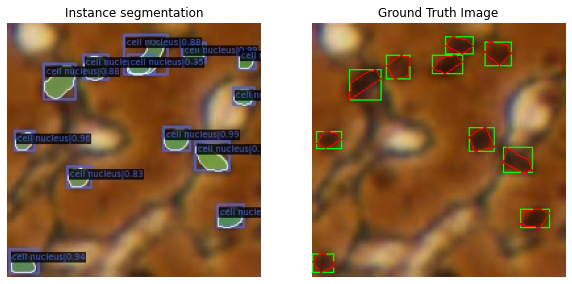

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J8_8_a_ann0016.jpg


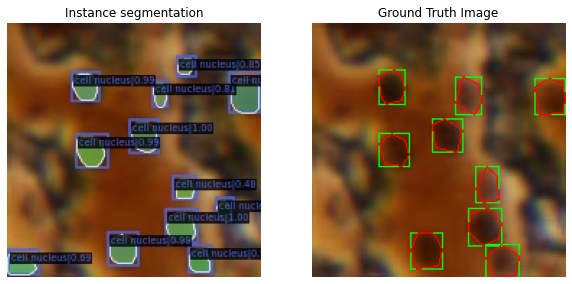

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J7_5_a_ann0029.jpg


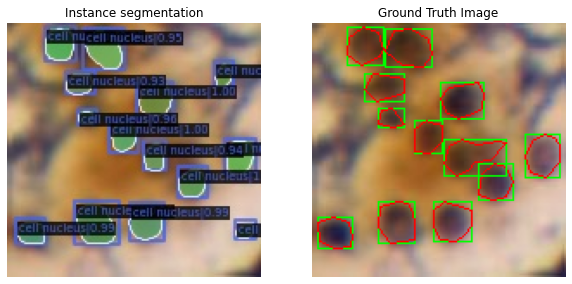

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J7_5_a_ann0011.jpg


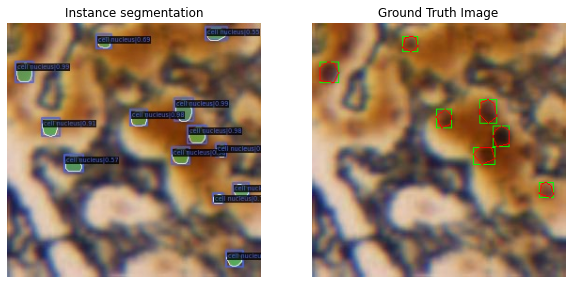

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J8_8_a_ann0008.jpg


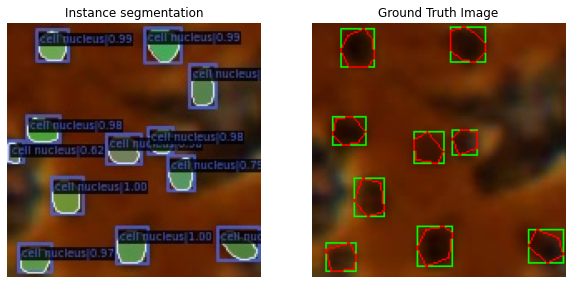

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J7_5_a_ann0018.jpg


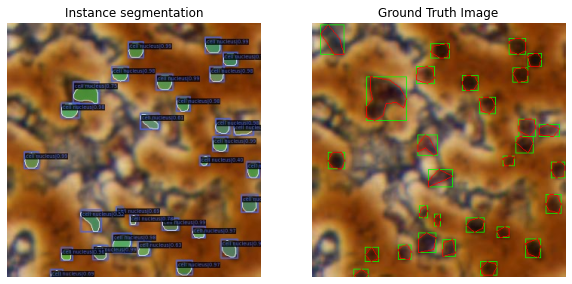

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J8_8_a_ann0016.jpg


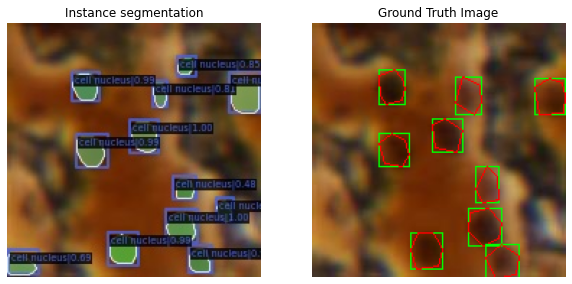

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J7_5_a_ann0011.jpg


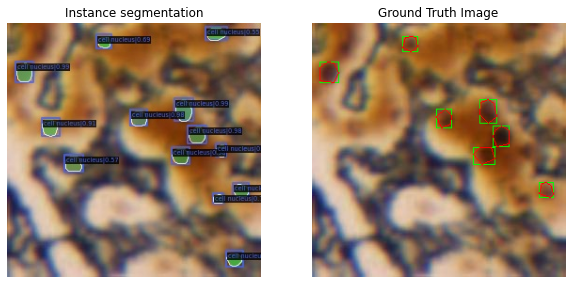

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J7_5_a_ann0029.jpg


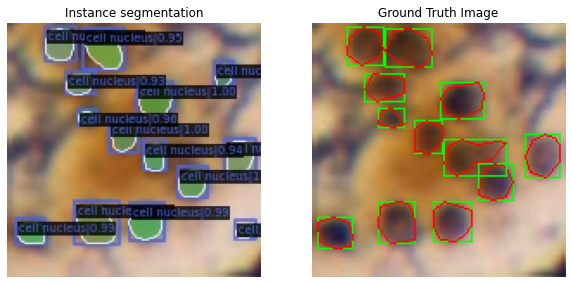

/scratch.ssd/jburian/job_20030823.meta-pbs.metacentrum.cz/data/orig/images/J8_8_a_ann0011.jpg


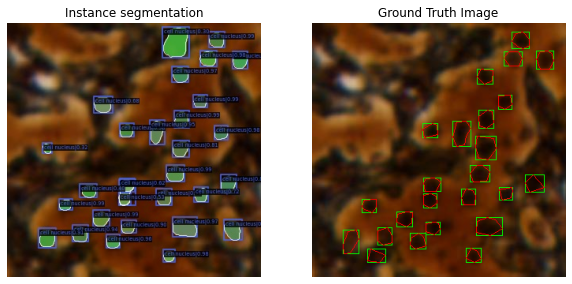

In [20]:
# Test data
path_test_images = local_input_data_dir / "images"
print(path_test_images)

with open(os.path.join(local_input_data_dir, 'test.json')) as json_file:
    test_images_dict = json.load(json_file)
    
images_names = []
image_IDs_dict = {}
for dict_image in test_images_dict['images']:
    images_names.append(dict_image['file_name'])
    image_IDs_dict[dict_image['file_name']] = dict_image['id']
    
# print(images_names)
# print(image_IDs_dict)

filelist = [file for file in path_test_images.glob('*.jpg') if file.name in images_names]
           
for img_fn in random.choices(filelist, k=10):
    image_name = os.path.basename(img_fn)
    image_ID = image_IDs_dict[image_name]
    # print(image_ID)
    
    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)
    
    print(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img)
    # show_result_pyplot(model, img, result)
    # save image with result 
    model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg") 
    loaded_image = cv2.imread(str(local_output_data_dir / f"pred_{img_fn.stem}.jpg"))
    img_ground_truth = get_image_ground_truth(img_fn, image_ID)
    
    # Create a figure with two subplots
    # plt.figure(figsize=(15, 5))

    # Plot the loaded_image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB))
    plt.title('Instance segmentation')
    plt.axis('off')

    # Plot the img_ground_truth
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_ground_truth, cv2.COLOR_BGR2RGB))
    plt.title('Ground Truth Image')
    plt.axis('off')

    plt.show()

# Using pretrained model

In [ ]:
# from mmdet.apis import init_detector, inference_detector
# import mmcv

# mmdetection_path = Path(mmdet.__file__).parent.parent

# # Specify the path to pretrained model config and checkpoint file
# config = cfg
# checkpoint_file = './epoch_12.pth'

# # build the model from a config file and a checkpoint file
# model = init_detector(config, checkpoint_file, device='cuda:0')

# path_test_images = local_input_data_dir

# filelist = list((path_test_images).glob("**/*.jpg"))
# filelist.extend(list((path_test_images).glob("**/*.JPG")))
# filelist.extend(list((path_test_images).glob("**/*.png")))
# filelist.extend(list((path_test_images).glob("**/*.PNG")))


# for img_fn in random.choices(filelist, k=3):

#     # img_fn = local_input_data_dir / '/images/10.jpg'
#     img = mmcv.imread(img_fn)

#     model.cfg = cfg
#     result = inference_detector(model, img)
#     show_result_pyplot(model, img, result)
#     # save image with result 
#     model.show_result(img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg") 

# Copy data to my home

In [ ]:
# dtstr = datetime.now().strftime("%Y%m%d_%H%M")
# # dtstr = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# !mkdir -p ~/data/processed/$dtstr

# output_path = str(Path("~/data/processed").expanduser() / dtstr)
# input_path = str(scratchdir/"data/processed/")

# !cp -r "$SCRATCHDIR"/data/processed/* {output_path} 
# !ls ~/data/processed/$dtstr
# print(dtstr)
# print(input_path)
# print(output_path)

In [ ]:
import shutil, errno

def copy_files(src, dst):
    try:
        shutil.copytree(src, dst)
    except OSError as exc: # python >2.5
        if exc.errno in (errno.ENOTDIR, errno.EINVAL):
            shutil.copy(src, dst)
        else: raise
        
dtstr = datetime.now().strftime("%Y%m%d_%H%M")
# dtstr = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

input_path = str(scratchdir/"data/processed/")
output_path = str(Path("~/data/processed").expanduser() / dtstr)
        
copy_files(input_path, output_path)
!ls ~/data/processed/$dtstr